# Sklearn vs. Custom 'From Scratch' API
Linear Regression

Objective:
The goal of this analysis is to model student academic performance as a function of
hours studied, previous scores, etc. predictors using linear regression. Additionally, we will validate that the results of our 'ml-from-scratch' API through comparison to Sklearn.

We will:
- Fit a linear regression model using scikit-learn
- Evaluate predictive performance
- Validate linear regression assumptions
- Validate 'ml-from-scratch' model

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

# Data Loading and Initial Data Inspection

Looking for:
* Null values
* Data types of all variables
* Obvious data quality issues
* Scale of numeric variables

In [58]:
data = pd.read_csv("/Users/johnathonmin/vscode/ml-from-scratch/data/Student_Performance.csv")
data.info()
data.head(5)
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


# Exploratory Data Analysis

Purpose:
* Early check of linearity asumption
* Identify any strong correlations
* Identify potential multicollinearity

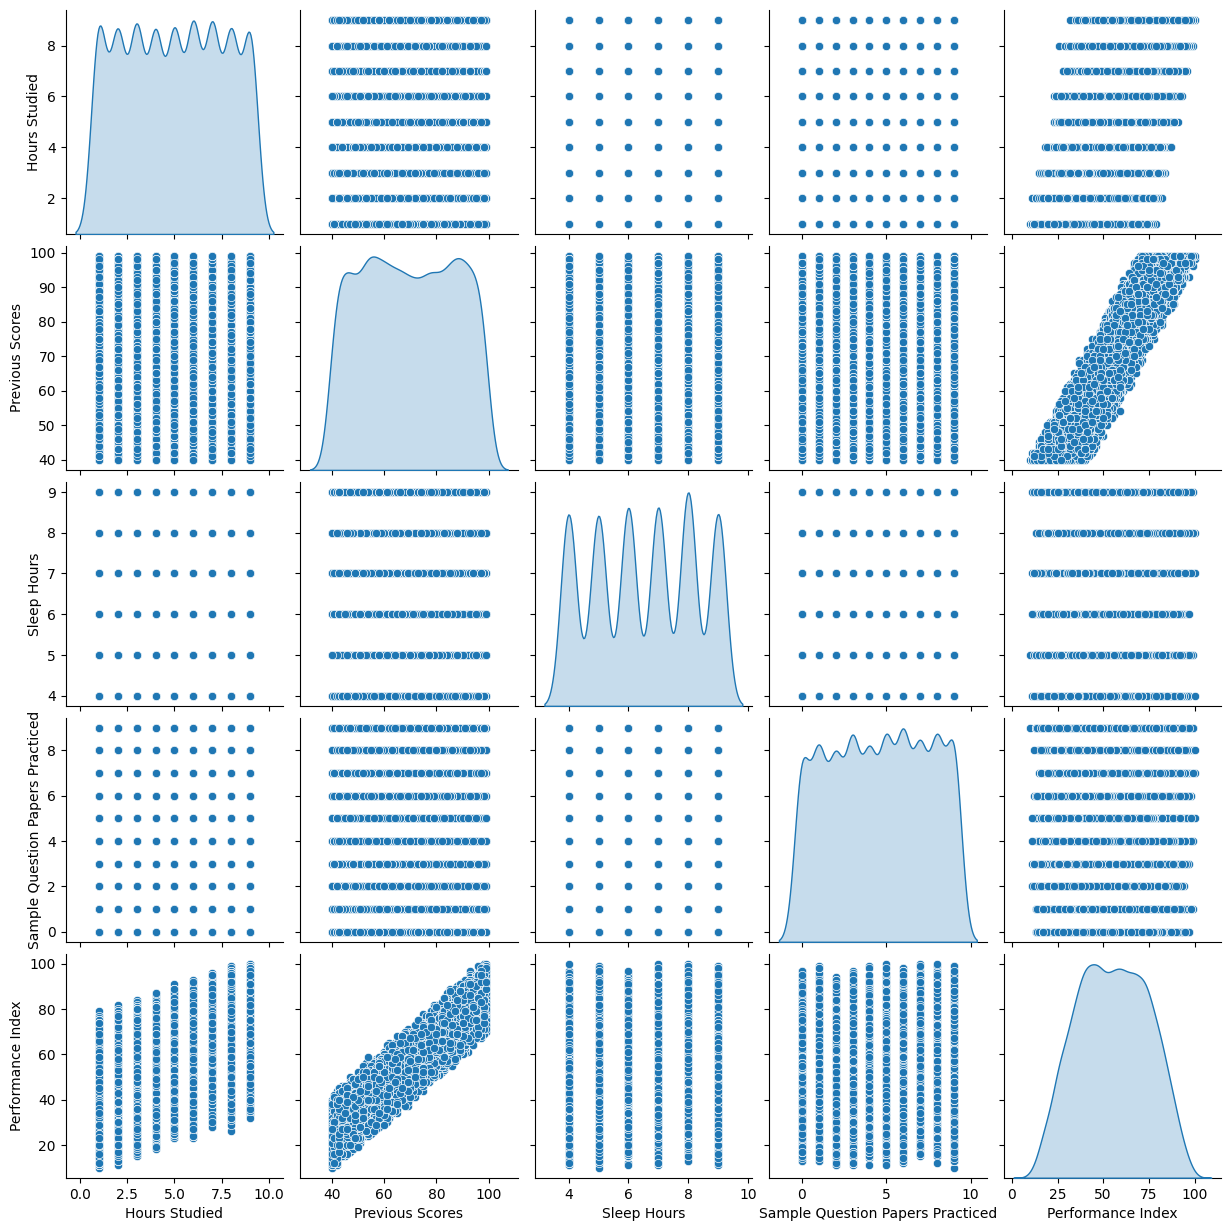

In [59]:
sns.pairplot(data, diag_kind="kde")

<Axes: >

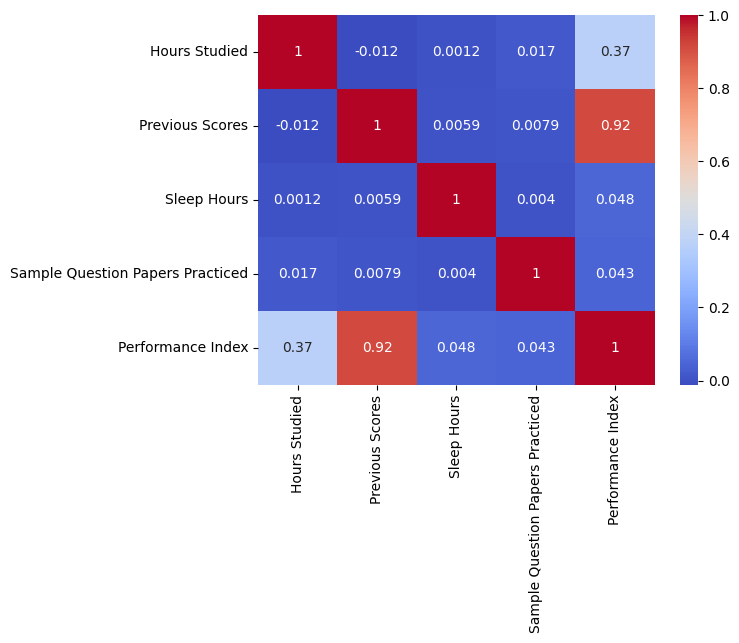

In [60]:
numerical_features = data.select_dtypes(include=[np.number])
corr_matrix = numerical_features.corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")     

# Feature Engineering and Preprocessing

# Train/Test Split

In [61]:
# Define target and features
target = "Performance Index"
X = data.drop(columns=[target])
y = data[target]

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=123
)

# Model Training (sklearn)

In [62]:
# Identify column types from the training set only
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())   # optional for LinearRegression; keep for extensibility
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

In [63]:
skl_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])

skl_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Hours Studied',
                                                   'Previous Scores',
                                                   'Sleep Hours',
                                                   'Sample Question Papers '
                                                   'Practiced']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Extracurricular '
                                                   'Activities'])])),
                ('regressor', LinearRegression())])

# Model Evaluation

In [65]:
# Standard metrics
y_pred = skl_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse, r2

/Users/johnathonmin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/johnathonmin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/johnathonmin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


(2.116513748769702, 0.9877171781991884)

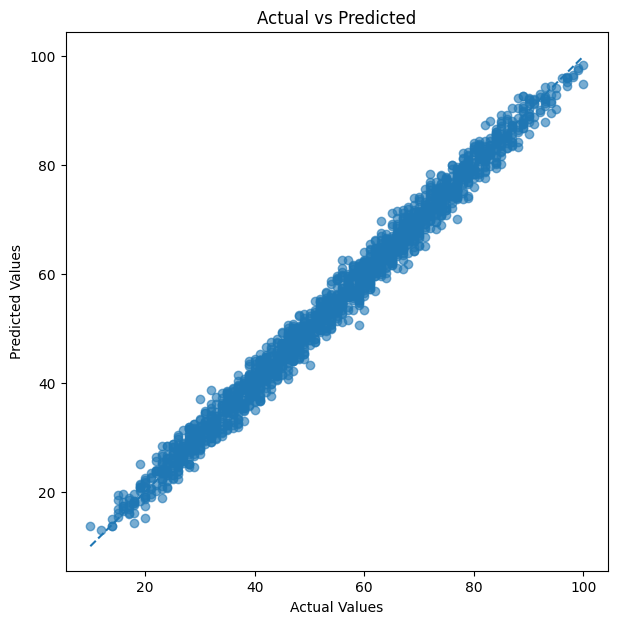

In [66]:
# Actual vs. Fitted
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()

In [70]:
# Explainability
# Get the trained LinearRegression inside the pipeline
lr = skl_model.named_steps["regressor"]
ct = skl_model.named_steps["preprocess"]

# Feature names after preprocessing
feature_names = ct.get_feature_names_out()

coef = pd.Series(lr.coef_, index=feature_names).sort_values()
coef.tail(20)  # top positive

num__Sample Question Papers Practiced     0.570841
cat__Extracurricular Activities_Yes       0.602397
num__Sleep Hours                          0.802367
num__Hours Studied                        7.389956
num__Previous Scores                     17.703451
dtype: float64

# Assumtion Diagnostics

* Linearity - confirmed
* Independence of Errors - assumed
* Homoscedasticity - confirmed
* Normality of Residuals - confirmed

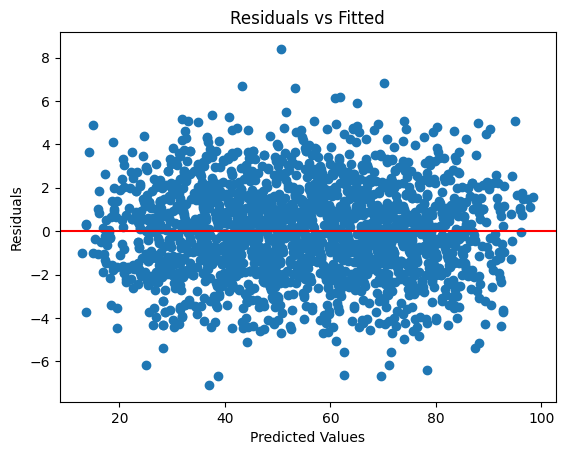

In [67]:
# Linearity - want to see random scatter around zero for residuals across all predicted values
# Homoscedastic as well
plt.scatter(y_pred, y_test - y_pred)
plt.axhline(0, color="red")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

<Axes: xlabel='Performance Index', ylabel='Count'>

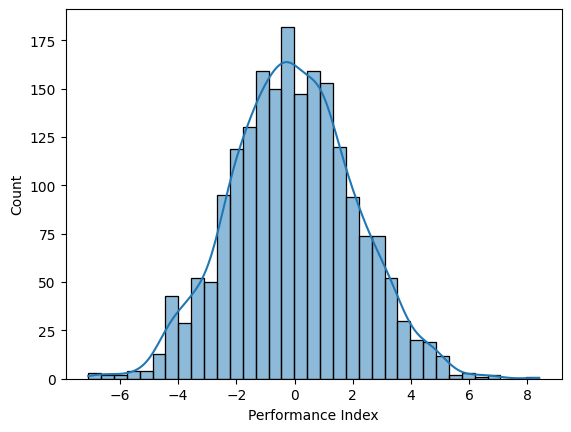

In [68]:
# Normality of residuals
sns.histplot(y_test - y_pred, kde=True)